
# Example prediction on a single test image
This notebook gives example code to make a single disparity prediction for one test image.

The file test_simple.py shows a more complete version of this code, which additionally:

Can run on GPU or CPU (this notebook only runs on CPU)
Can predict for a whole folder of images, not just a single image
Saves predictions to .npy files and disparity images.

In [ ]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
import networks
from utils import download_model_if_doesnt_exist

# Setting up network and loading weights¶


In [ ]:
model_name = "mono_640x192"

download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval();

# Loading the test image and preprocessing

In [ ]:
def prepare_image(input_image,  w, h):
    input_image_resized = input_image.resize((w, h), pil.LANCZOS)
    return transforms.ToTensor()(input_image_resized).unsqueeze(0)

# Prediction using the PyTorch model


In [ ]:
def prdict_om_image(input_image_pytorch):
    with torch.no_grad():
        features = encoder(input_image_pytorch)
        outputs = depth_decoder(features)

    return outputs[("disp", 0)]

# Plotting

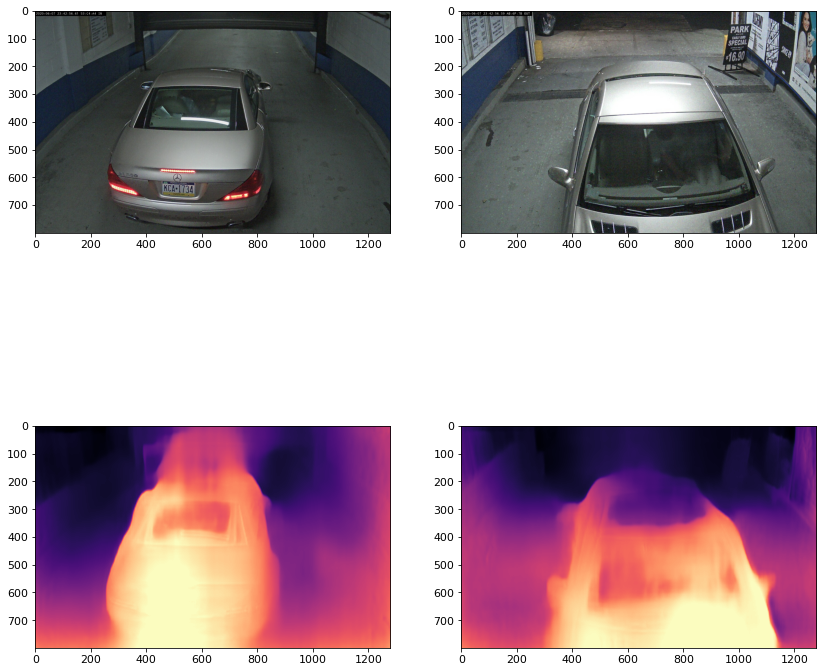

In [ ]:
image_path1 = "./data/entry1/1591587776858.jpg"
image_path2 =  "./data/exit1/1591587776850.jpg"

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image1 = pil.open(image_path1).convert('RGB')
input_image2 = pil.open(image_path2).convert('RGB')

image1 = prepare_image(input_image1, feed_width, feed_height)
image2 = prepare_image(input_image2, feed_width, feed_height)

(original_width, original_height) = input_image1.size

disp1 = prdict_om_image(image1)
disp2 = prdict_om_image(image2)

disp_resized1 = torch.nn.functional.interpolate(disp1,
    (original_height, original_width), mode="bilinear", align_corners=False)

disp_resized2 = torch.nn.functional.interpolate(disp2,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np1 = disp_resized1.squeeze().cpu().numpy()
disp_resized_np2 = disp_resized2.squeeze().cpu().numpy()

vmax1 = np.percentile(disp_resized_np1, 95)
vmax2 = np.percentile(disp_resized_np2, 95)

fig = plt.figure(figsize=(14, 14))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(input_image1)
#ax1.title = "Input1"
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(input_image2)
#ax2.title = "Input2"

ax3 = fig.add_subplot(2,2,3)
ax3.imshow(disp_resized_np1, cmap='magma', vmax=vmax1)
#ax3.title = "Disparity prediction1"
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(disp_resized_np2, cmap='magma', vmax=vmax2)
#ax4.title = "Disparity prediction2"


# Object detector usage


In [ ]:
import yolov5
yolo = yolov5.YOLOv5("models/yolov5s.pt", device="cpu")

# load images
image1 = pil.open("./data/entry1/1591587776858.jpg")
image2 = pil.open("./data/exit1/1591587776850.jpg")

result = yolo.predict([image1, image2])
result.show()

Adding autoShape... 


In [ ]:
result.xywhn

[tensor([[0.44029, 0.61034, 0.47682, 0.72183, 0.43397, 2.00000]]),
 tensor([], size=(0, 6))]

# Task
Assuming that zones are overlaping use disparsity data and object detection to map those zones and create geometrical transformation that would allow generating expected missing bounding box on opposite camera.



# Solution
Unfortunately, I was not able to meet the goals from the task, i.e., to find a proper mapping between the zones.

Some ideas are roughly presented below, but generally, I ended up with an alternative solution to find bounding boxes on the image from the opposite camera.

# Perspective transform
One of my ideas was to geometrically transform both images to produce a bird's eye view. I thought that this tool can be useful for later merge of two images: from exit and from entry. 

Note that, in order to obtain a desired homography transformation, I hard-coded the points in `src` based on the visual properties of the images (characteristic corners of the curb near the road and the wall).

Below there are 2 methods which implement transforms for entry and exit camera.

In [ ]:
def perspective_transform_camera1(img): 
    height =  img.shape[0]
    width =  img.shape[1]
    y_level = 200
    y_level2 = 490
    top_offset = 100
    side_offset = 250
    src = np.float32([[370, y_level],[1030, y_level],[width, y_level2],[0, y_level2]])
    dst = np.float32([[side_offset, top_offset], [width-side_offset, top_offset],
                      [width-side_offset, height-200],[side_offset, height-200]])
        
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped, M, Minv

In [ ]:
def perspective_transform_camera2(img): 
    height =  img.shape[0]
    width =  img.shape[1]
    y_level = 200
    y_level2 = 490
    top_offset = 100
    side_offset = 250
    src = np.float32([[210, y_level],[1030, y_level],[width, y_level2],[0, y_level2]])
    dst = np.float32([[side_offset-35, top_offset], [width-side_offset+35, top_offset],
                      [width-side_offset, height-200],[side_offset, height-200]])
        
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped, M, Minv

# Tests of the transform
Tests are executed on images from 2 cameras. 

Transformation is made both on the original image and on the image from depth estimator.

In [ ]:
def conv2RGB(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [ ]:
import cv2
img = cv2.imread('./data/entry1/1591587776858.jpg')
img2 = cv2.imread('./data/exit1/1591587776850.jpg')

img=conv2RGB(img)
img2=conv2RGB(img2)

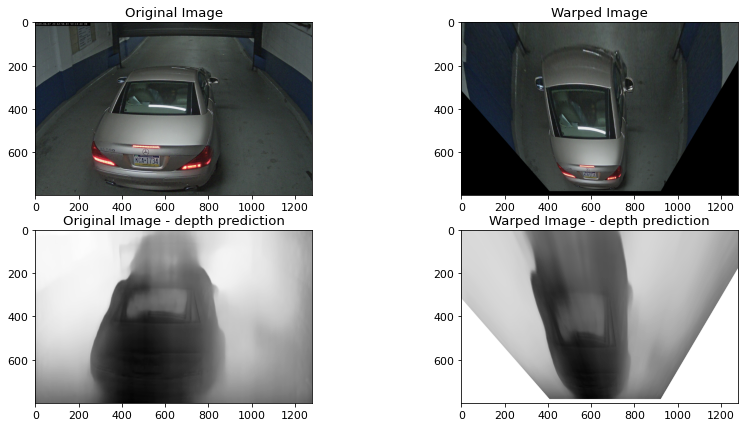

In [ ]:
warped_img, M, Minv = perspective_transform_camera1(img)
warped_disp_resized_np1, M, Minv = perspective_transform_camera1(disp_resized_np1)

fig = plt.figure(figsize=(14, 7))
plt.subplot(221), plt.imshow(img), plt.title('Original Image')
plt.subplot(222), plt.imshow(warped_img), plt.title('Warped Image')
plt.subplot(223), plt.imshow(disp_resized_np1, cmap='Greys'), plt.title('Original Image - depth prediction')
plt.subplot(224), plt.imshow(warped_disp_resized_np1, cmap='Greys'), plt.title('Warped Image - depth prediction')

plt.show()

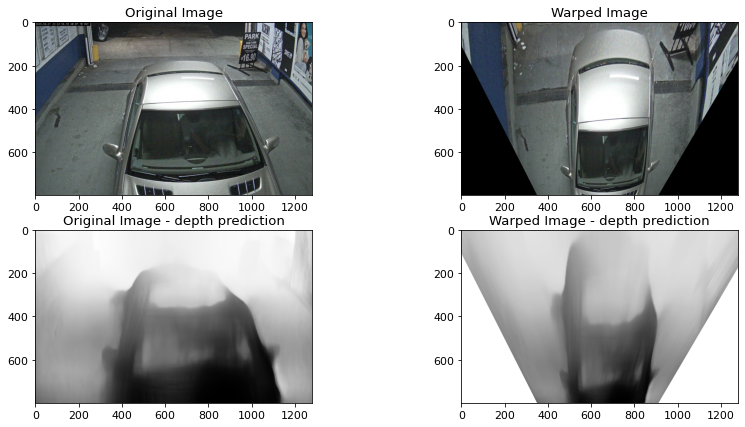

In [ ]:
warped_img2, M, Minv = perspective_transform_camera2(img2)
warped_disp_resized_np2, M, Minv = perspective_transform_camera2(disp_resized_np2)

fig = plt.figure(figsize=(14, 7))
plt.subplot(221), plt.imshow(img2), plt.title('Original Image')
plt.subplot(222), plt.imshow(warped_img2), plt.title('Warped Image')
plt.subplot(223), plt.imshow(disp_resized_np2, cmap='Greys'), plt.title('Original Image - depth prediction')
plt.subplot(224), plt.imshow(warped_disp_resized_np2, cmap='Greys'), plt.title('Warped Image - depth prediction')

plt.show()

# Discussion
The transformation shown above works perfect if we transform an image which has one plane (e.g. a book, a wall in a building). In our analysed images, we have obviously many depths (a car). So, it would be an interesting research how to modify a homography transformation which takes into account the depth. 

The primary reason why I created a bird's eye view is that I wanted to somehow merge, stitch the images from the exit and entry. This would create a map of a car based on 2 images. This is normally done by SIFT or SURF methods (which would match characteristic points in both images). Unfortunately in current version of OpenCV, these algorithms are no longer available (patent protected). 

We could also think about mapping the images (either directly or after above transformation) based on the information from depth predictor. E.g. considering that some points from exit camera (with the least depth) are representing the same feature of a car that the points from entry camera (with the greatest depth). But, except the car, there is also a background on the images, which would make this solution much harder. 

# Histograms
I created some histograms, just to see the properties of images which are the outputs of depth predictor.
On the right hand side, there is also a histogram of a depth predictor on an image where a mask was applied - based on yolo detection (car detected).

In [ ]:
result.xyxy
result_first_bbox = result.xyxy[0][0].numpy()
start_point = (result_first_bbox[0], result_first_bbox[1])
stop_point = (result_first_bbox[2], result_first_bbox[3])

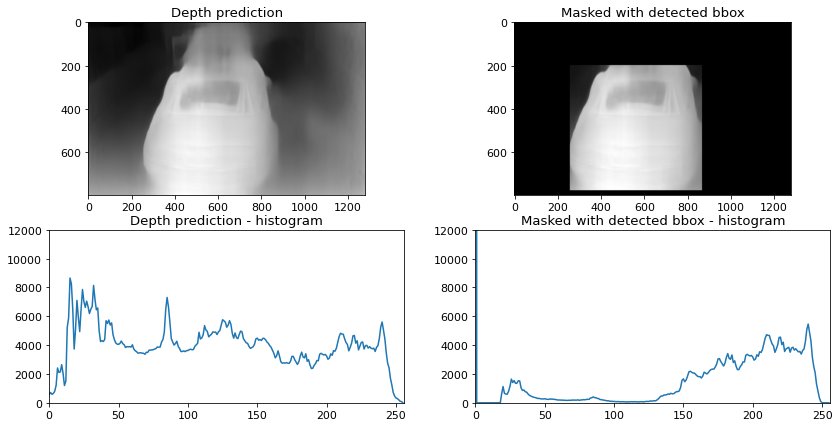

In [ ]:
norm_image = cv2.normalize(disp_resized_np1, disp_resized_np1, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX)

height,width = disp_resized_np1.shape
detected_area_mask = np.zeros((height,width), np.uint8)
cv2.rectangle(detected_area_mask, start_point, stop_point, (255,255,255), -1)
masked_image = cv2.bitwise_and(norm_image, norm_image, mask = detected_area_mask)

hist_full = cv2.calcHist([norm_image],[0],None,[256],[0,256])
hist_masked = cv2.calcHist([masked_image],[0],None,[256],[0,256])

fig = plt.figure(figsize=(14, 7))
plt.subplot(221), plt.imshow(norm_image, 'gray'), plt.title('Depth prediction')
plt.subplot(222), plt.imshow(masked_image,'gray'), plt.title('Masked with detected bbox')
plt.subplot(223), plt.plot(hist_full), plt.ylim([0,12000]), plt.xlim([0,256]), plt.title('Depth prediction - histogram')
plt.subplot(224), plt.plot(hist_masked), plt.ylim([0,12000]), plt.xlim([0,256]), plt.title('Masked with detected bbox - histogram')

plt.show()

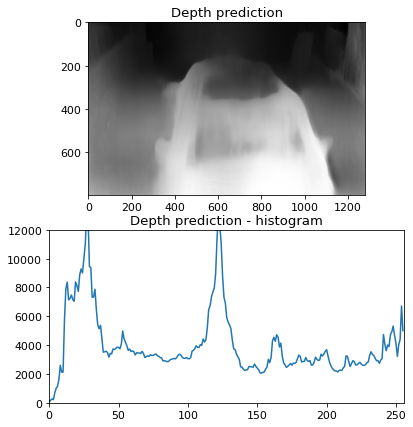

In [ ]:
norm_image2 = cv2.normalize(disp_resized_np2, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8UC1)

hist = cv2.calcHist([norm_image2],[0],None,[256],[0,256])

fig = plt.figure(figsize=(14, 7))
plt.subplot(221), plt.imshow(norm_image2, 'gray'), plt.title('Depth prediction')
plt.subplot(223), plt.plot(hist), plt.ylim([0,12000]), plt.xlim([0,256]), plt.title('Depth prediction - histogram')

plt.show()

# Disussion
Having tried some methods to map 2 images from exit and entry camera (unsuccessfully), I decided to follow a simpler approach. It won't be so stable and accurate, but it will result in more or less proper bounding box placed on the image from exit camera. It will be based on simple analysis of a histogram of the depth image.



# Getting a blob (mask based on threshold)
Firstly, I experimentally found a threshold (from above histogram `Masked with detected bbox - histogram`) which could tell which pixel belongs to a car and which does not. It was set to 150 as seen below.

Then, to eliminate holes inside the blob, I applied some erosion and dilation on an image.

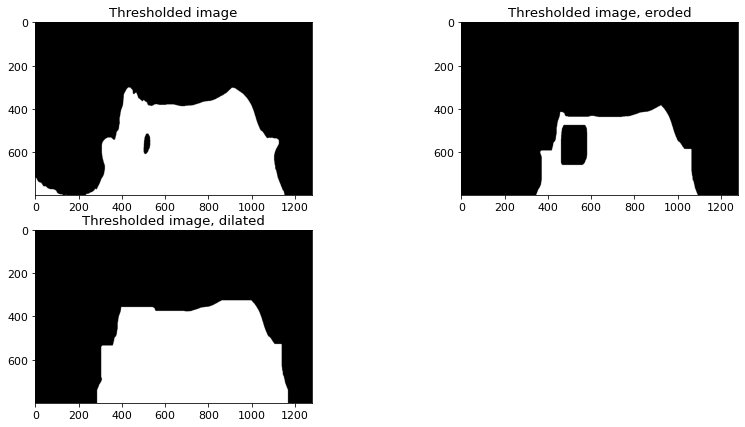

In [314]:
height,width = norm_image2.shape
THRESH = 150

norm_image2_modified = np.zeros((height,width), np.uint8)
norm_image2_modified = norm_image2.copy()
ret2, norm_image2_modified = cv2.threshold(norm_image2_modified, THRESH, 255, cv2.THRESH_BINARY)

kernel = np.ones((10, 10),np.uint8)
erosion = cv2.erode(norm_image2_modified,kernel,iterations = 10)
dilation = cv2.dilate(erosion,kernel,iterations = 15)

fig = plt.figure(figsize=(14, 7))
plt.subplot(221), plt.imshow(norm_image2_modified, 'gray'), plt.title('Thresholded image')
plt.subplot(222), plt.imshow(erosion,'gray'), plt.title('Thresholded image, eroded')
plt.subplot(223), plt.imshow(dilation, 'gray'), plt.title('Thresholded image, dilated')

plt.show()

# Finding a bounding box
Having a blob from upper stage, we can draw a rectangle around it.

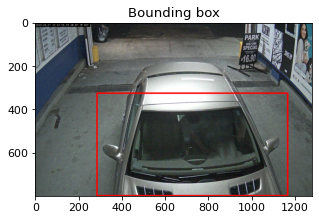

In [315]:
contours,_ = cv2.findContours(dilation.copy(), 1, 1)

rect = cv2.minAreaRect(contours[0])
(x,y),(w,h), a = rect # a - angle

cv2.rectangle(img2, (int(x-w/2), int(y-h/2)), (int(x+w/2), int(y+h/2)), (255, 0, 0), 5)

fig = plt.figure(figsize=(14, 7))
plt.subplot(221), plt.imshow(img2), plt.title('Bounding box')

plt.show()

# Implementation of a pipeline
Following the simple pattern described above (thresholding a depth image, finding a blob, and corresponding bbox) the pipeline is created below. It is mostly utilizing the code from above cells.

In [ ]:
# takes a path with an image and returns the "depth" image 
def get_depth_prediction(path):
  input_image1 = pil.open(path).convert('RGB')

  feed_height = loaded_dict_enc['height']
  feed_width = loaded_dict_enc['width']
  image1 = prepare_image(input_image1, feed_width, feed_height)

  (original_width, original_height) = input_image1.size

  disp1 = prdict_om_image(image1)

  disp_resized1 = torch.nn.functional.interpolate(disp1,
      (original_height, original_width), mode="bilinear", align_corners=False)

  disp_resized_np1 = disp_resized1.squeeze().cpu().numpy()

  return disp_resized_np1

In [ ]:
#takes an image which is binary thresholded with a parameter THRESH. Then, erosion and dilation is performed to obtain a blob.
def get_mask_higher_depths(img):
  THRESH = 150
  norm_image = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8UC1)

  height,width = norm_image.shape
  norm_image_thresh = np.zeros((height,width), np.uint8)
  norm_image_thresh = norm_image.copy()
  ret2, norm_image_thresh = cv2.threshold(norm_image_thresh, THRESH, 255, cv2.THRESH_BINARY)

  kernel = np.ones((10, 10),np.uint8)
  erosion = cv2.erode(norm_image_thresh,kernel,iterations = 10)
  dilation = cv2.dilate(erosion,kernel,iterations = 15)

  return dilation

In [ ]:
# Creates a rectangle around an image with blob
def get_bbox_from_mask(mask):
  contours,_ = cv2.findContours(mask.copy(), 1, 1)
  rect = cv2.minAreaRect(contours[0])

  return rect

In [ ]:
# Draws a bounding box in an image
def apply_bbox(img, rect):
  (x,y),(w,h), a = rect
  cv2.rectangle(img, (int(x-w/2), int(y-h/2)), (int(x+w/2), int(y+h/2)), (255, 0, 0), 5)
  return img


In [ ]:
# Calculates the area of a detected object
def get_first_camera_object_area(path):
  image = pil.open(path)
  result = yolo.predict(image)
  res = result.xywhn[0][0].numpy()
  w = res[2]
  h = res[3]

  return w*h


In [ ]:
# Produces a ROI mask (points specified in contours and contours2 have been manually chosen)
def get_simple_roi_mask(image):
  height,width = image.shape

  mask1 = np.ones((height,width), np.uint8)
  contours = np.array([[0,0], [0,height], [250,height], [350,0]])
  cv2.fillPoly(mask1, pts = [contours], color =(0,0,0))

  mask2 = np.ones((height,width), np.uint8)
  contours2 = np.array([[width,height], [width,0], [1000,0]])
  cv2.fillPoly(mask2, pts = [contours2], color =(0,0,0))

  masked_image = cv2.bitwise_and(image, image, mask = mask1)
  masked_image = cv2.bitwise_and(masked_image, masked_image, mask = mask2)

  return masked_image

# Final pipeline stacking all above methods
It is improtant to mention that one tweak was done here: The whole pipeline is being calculated only if detected car from entry camera is large enough. It means that we don't want to perform the pipeline if the car is far away - then, it's probably not visible in exit camera. 

In [ ]:
# Final pipeline stacking all above methods
def get_bbox_pipline(path, area_first_camera_object):
  original_img = cv2.imread(path)
  original_img = conv2RGB(original_img)

  if (area_first_camera_object > 0.10):
    img_depth = get_depth_prediction(path)
    mask = get_simple_roi_mask(img_depth)
    mask = get_mask_higher_depths(mask)
    rect = get_bbox_from_mask(mask)
    original_img = apply_bbox(original_img, rect)

  return original_img

# Tests
Tests on images from exit camera have been performed. Note that not each image is shown as a result of the code. A step of 10 was used when iterating the list of images - for the sake of computation speed.


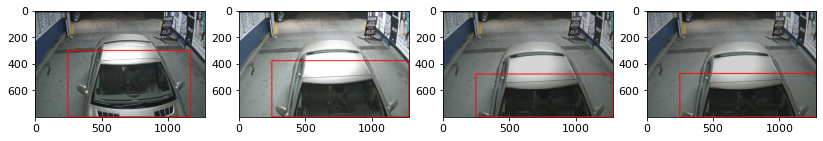

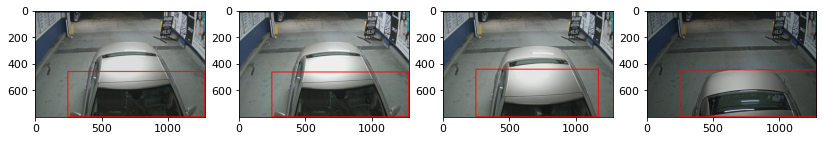

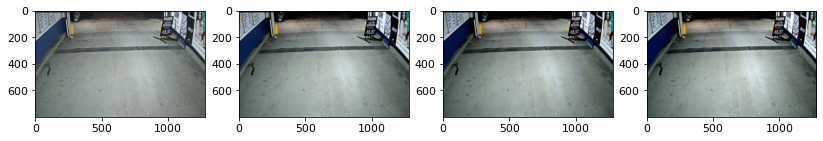

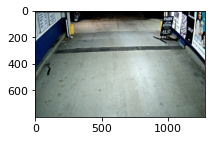

In [313]:
from glob import glob
from pathlib import Path
data_source1 = glob("./data/exit1/*")
data_source2 = glob("./data/entry1/*")
data_source1.sort(key= lambda x: int(Path(x).stem))
data_source2.sort(key= lambda x: int(Path(x).stem))

fig = plt.figure(figsize=(14, 7))
cnt = 0

for i in range(len(data_source1))[::10]:
    area = get_first_camera_object_area(data_source2[i])

    img = get_bbox_pipline(data_source1[i], area)

    cnt = cnt % 4
    fig.add_subplot(1, 4, cnt+1)
    plt.imshow(img)
    
    if cnt == 3:
      plt.show()
      fig = plt.figure(figsize=(14, 7))
    cnt = cnt + 1
